<div style="text-align: center;">
    <h1><strong> 🚗🚌🚲 A Deep Learning Approach to Traffic Object Detection: YOLO11 and DETR on CCTV Datasets🚦</strong></h1>
    <h5>Thanks for visiting my notebook</h5>
    <img src="./images/p1.png" alt="Description" style="width: 612; height: 408px">
</div>

**Author**: Huy Nguyen <br>
**Last Updated**: 2025-06-01

#  🔍 Overview
<div style="background-color: rgb(208, 242, 255); padding: 20px; font-family: Arial, sans-serif; color: #333; line-height: 1.5;">
<p style='font-size: 20px;'>
Traffic object detection is a critical AI-driven task that involves identifying and classifying objects such as bicycles, buses, and cars in images or video streams, typically from CCTV cameras, dashcams, or drones. This technology plays a vital role in smart city infrastructure, autonomous vehicles, traffic management, and road safety analytics. <br>
With advancements in deep learning and computer vision, modern systems can detect and track mutilple object in real-time, even in complex urban environments. State-of-the-art models like <strong>YOLO (You Only Look Once)</strong> and <strong>DETR (Detection Transformer)</strong> enable high-speed, accurate detection by analyzing visual patterns in large datasets.<br>
</p>
<p style='font-size: 20px'>
This notebook provides a comprehensive benchmark of YOLO11 and DETR-Resnet50 architectures for CCTV-based traffic analysis, evaluating their suitability for smart city developments.
</p>
</div>

# 📝 Table of contents
1. <a href='#dataset'>Dataset Description</a>
2. <a href='#methodology'>Methodology</a>
4. <a href='#conclusion'>Conclusion</a>
3. <a href='#references'>References</a>

# Dataset Description

# 📂 Data Sources
| Dataset Name       | Source | Classes | Resolution | License |
|--------------------|--------|---------|------------|---------|
| [Street View](https://www.kaggle.com/datasets/yusufberksardoan/traffic-detection-project/data) | Kaggle | 5<br> [bicycle, bus, car, motorbike, person] | 640x640 | CC BY 4.0 |
| [Street View](https://universe.roboflow.com/fsmvu/street-view-gdogo/dataset/1) | Roboflow | 5<br> [bicycle, bus, car, motorbike, person] | 640x640 | CC BY 4.0 |

The dataset includes 6633 images. <br>

# 📊 Preview dataset

### Import Necessary Libraries

In [3]:
#Hide warnings
import warnings
warnings.filterwarnings('ignore') 

#File handling
from glob import glob
import os
import yaml
from tqdm import tqdm

import numpy as np

#Plot the data
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import cv2
from PIL import Image
import supervision as sv

#DETR 
from transformers import DetrForObjectDetection, DetrConfig
#YOLO 
from ultralytics import YOLO

#Pytorch
import torch
from torchvision.transforms import transforms as T
from torchvision.ops import box_convert


### Load yaml file 

In [4]:
config=yaml.safe_load(open('src/config.yaml'))

### Create a dataframe

In [19]:
annotation_paths=sorted(glob("datasets/train/labels/*"))
img_paths=sorted(glob("datasets/train/images/*"))

df=[]

for i, path in enumerate(tqdm(annotation_paths, desc="Parsing txt", colour="cyan")):
    try:
        data=pd.read_csv(path, sep='\s+', header=None)
        data['img_path']=img_paths[i]
        df.append(data)
    except pd.errors.EmptyDataError: 
        continue #Skip the file which no data

df=pd.concat(df, ignore_index=True)

Parsing txt: 100%|██████████| 5805/5805 [00:07<00:00, 827.85it/s]


In [21]:
df.columns=["category", "x_center", "y_center", "width", "height", "img_path"]
labels=config['names'] #['bicycle', 'bus', 'car', 'motorbike', 'person']

df['category']=df['category'].map(lambda x: labels[int(x)]) 

In [23]:
df.head()

category  x_center  y_center     width    height  \
0    bicycle  0.498437  0.907813  0.045312  0.181250   
1    bicycle  0.537500  0.866406  0.039062  0.168750   
2  motorbike  0.636719  0.274219  0.021875  0.076563   
3     person  0.892969  0.442188  0.209375  0.245312   
4        car  0.776563  0.272656  0.064062  0.085938   

                                            img_path  
0  datasets/train/images/aguanambi-1000_png_jpg.r...  
1  datasets/train/images/aguanambi-1000_png_jpg.r...  
2  datasets/train/images/aguanambi-1000_png_jpg.r...  
3  datasets/train/images/aguanambi-1000_png_jpg.r...  
4  datasets/train/images/aguanambi-1000_png_jpg.r...

In [22]:
print(df.head().to_markdown())

|    | category   |   x_center |   y_center |     width |    height | img_path                                                                             |
|---:|:-----------|-----------:|-----------:|----------:|----------:|:-------------------------------------------------------------------------------------|
|  0 | bicycle    |   0.498437 |   0.907813 | 0.0453125 | 0.18125   | datasets/train/images/aguanambi-1000_png_jpg.rf.0ab6f274892b9b370e6441886b2d7b9d.jpg |
|  1 | bicycle    |   0.5375   |   0.866406 | 0.0390625 | 0.16875   | datasets/train/images/aguanambi-1000_png_jpg.rf.0ab6f274892b9b370e6441886b2d7b9d.jpg |
|  2 | motorbike  |   0.636719 |   0.274219 | 0.021875  | 0.0765625 | datasets/train/images/aguanambi-1000_png_jpg.rf.0ab6f274892b9b370e6441886b2d7b9d.jpg |
|  3 | person     |   0.892969 |   0.442188 | 0.209375  | 0.245312  | datasets/train/images/aguanambi-1000_png_jpg.rf.0ab6f274892b9b370e6441886b2d7b9d.jpg |
|  4 | car        |   0.776563 |   0.272656 | 0.0640625 | 

### Show random images

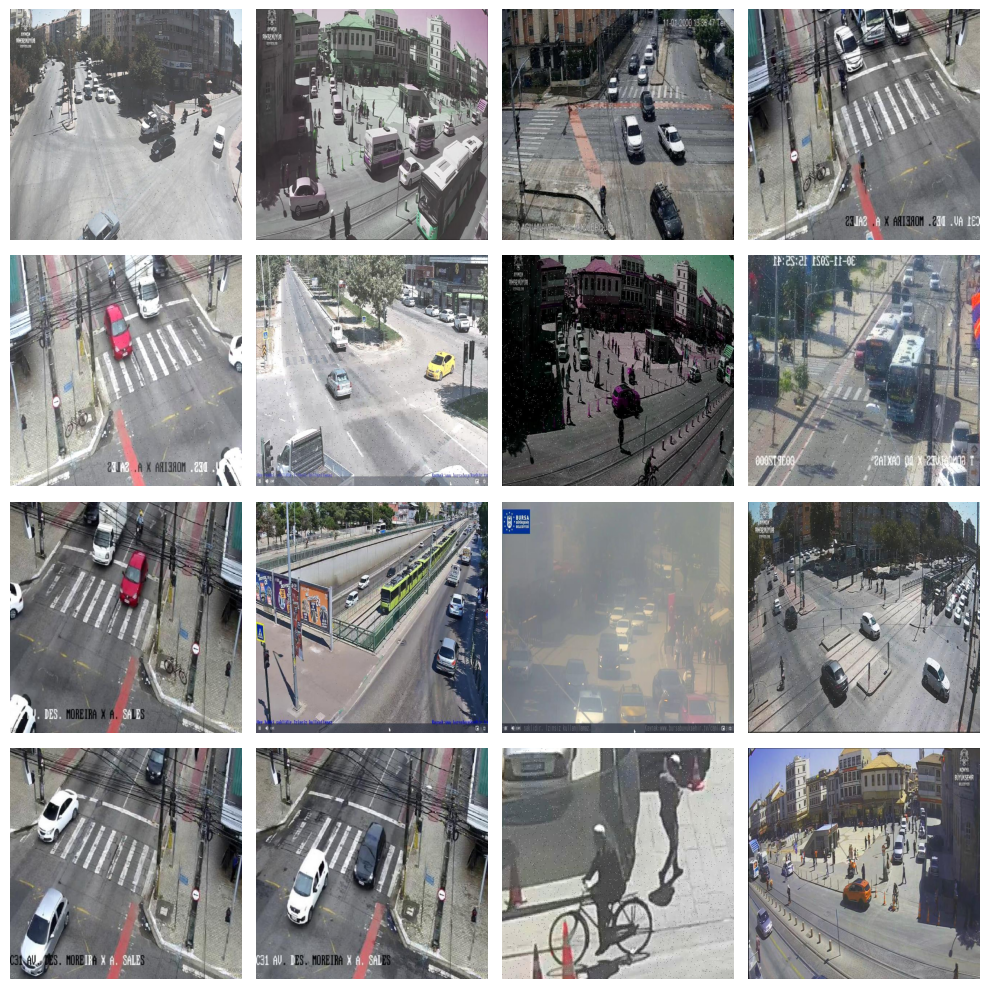

In [5]:
u_imgs = df["img_path"].unique()
path = np.random.choice(u_imgs, 16, replace=False)

fig, axes=plt.subplots(4,4, figsize=(10,10))

for i, ax in enumerate(axes.flat):
    img=plt.imread(path[i])
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show()

### Samples

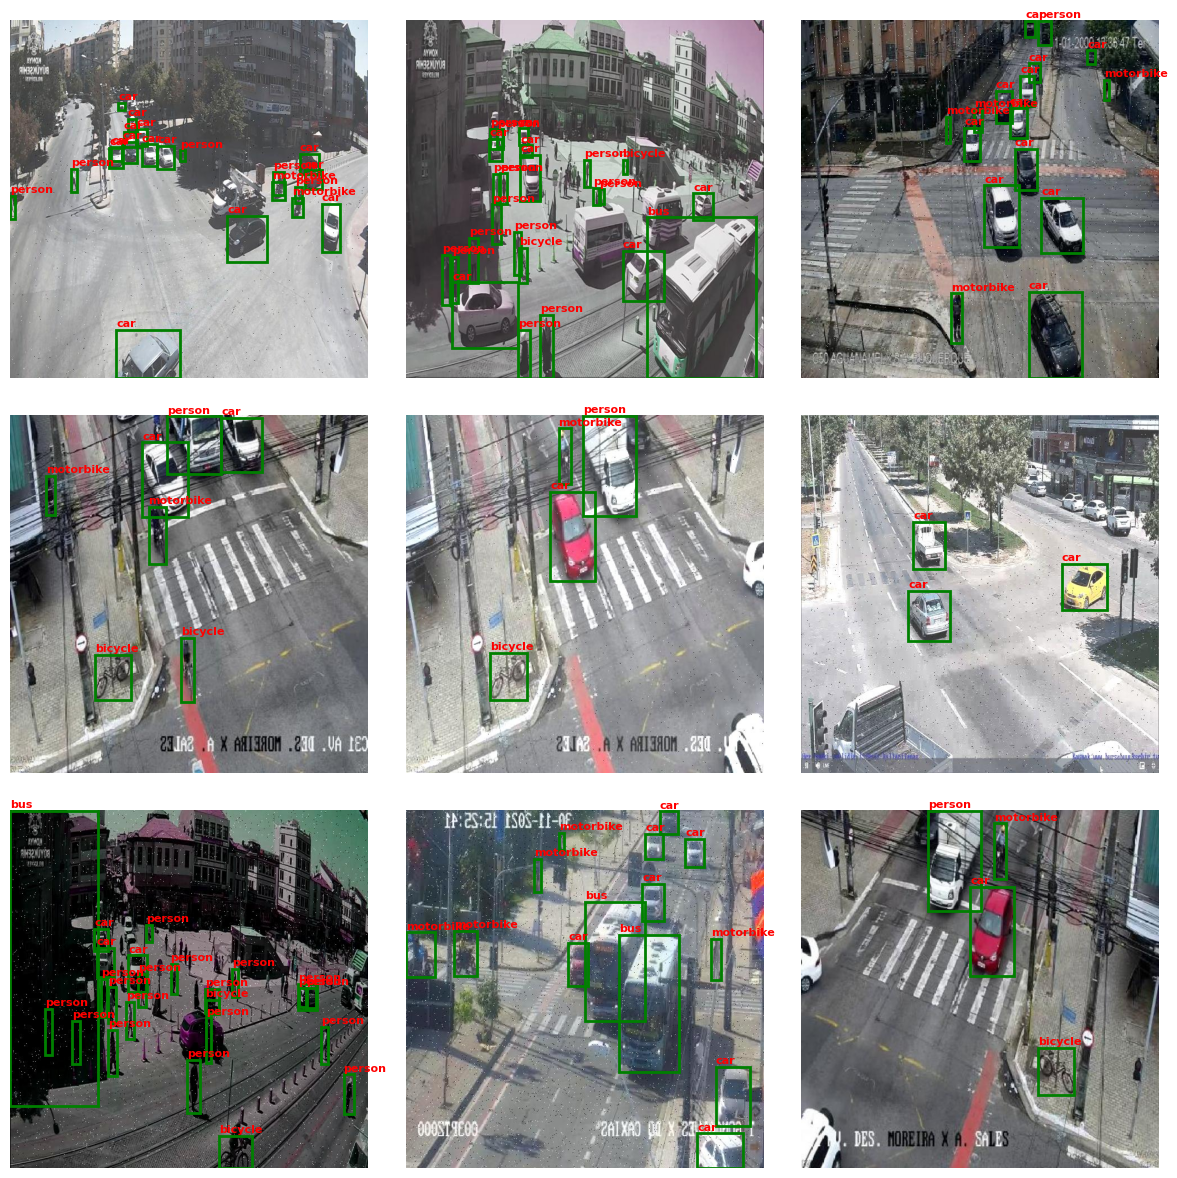

In [6]:
grouped= df.groupby('img_path')
fig, axes= plt.subplots(3,3, figsize=(12,12))
for i, ax in enumerate(axes.flat):
    img = plt.imread(path[i])
    ax.imshow(img)
    height, width= img.shape[:2]
    group=grouped.get_group(path[i])
    annotations=group[['x_center', 'y_center', 'width', 'height']].values
    categories=group['category'].values

    for ann, category in zip(annotations, categories):
        cx, cy, w, h= ann
        #convert to pixel
        cx, w= cx*width, w*width
        cy, h= cy*height, h*height

        #calculate top-left corner
        x,y= cx-w/2, cy-h/2

        ax.add_patch(Rectangle((x,y), w, h, edgecolor='green', facecolor='none', lw=2))
        ax.text(x, y-5, category, color='red', fontsize=8, weight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()

### Labels distribution

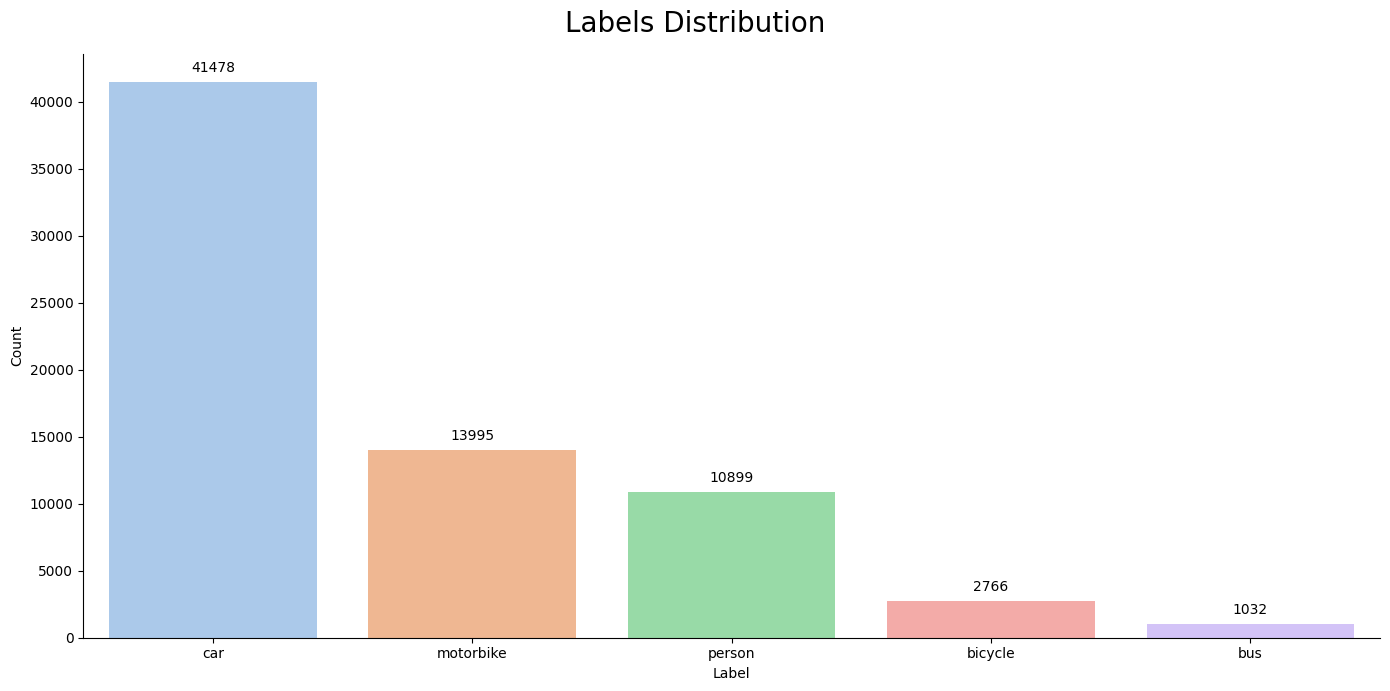

In [7]:
fig, axes=plt.subplots(1,1, figsize=(14,7))
label_counts=df['category'].value_counts()

sns.barplot(x=label_counts.index, y=label_counts.values, palette="pastel", ax= axes)

for container in axes.containers:
    axes.bar_label(container, label_type='edge', fmt='%.0f', padding=5)

axes.set_xlabel("Label")
axes.set_ylabel("Count")
axes.spines[['top', 'right']].set_visible(False)
fig.suptitle("Labels Distribution", fontsize=20)

plt.tight_layout()
plt.show()

### Spatial Distribution

In the **YOLO** format: <br>
X=0 is the left edge, X=1 is the right edge. <br>
Y=0 is the top edge, Y=1 is the bottom edge.

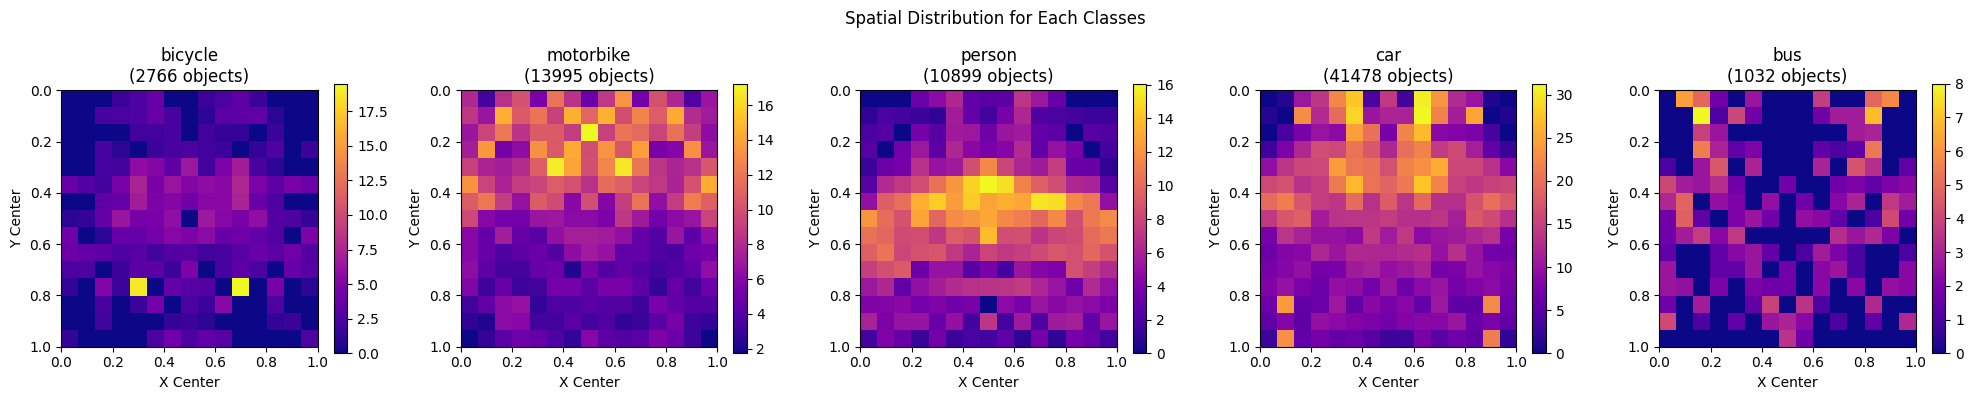

In [8]:
def category_heatmap(df):
    categories = df['category'].unique()
    n_cats = len(categories)
    
    fig, axes = plt.subplots(1, n_cats, figsize=(4*n_cats, 4))
    if n_cats == 1:
        axes = [axes]
    
    for i, cat in enumerate(categories):
        cat_data = df[df['category'] == cat]
        
        h, _, _ = np.histogram2d(cat_data['x_center'], cat_data['y_center'], bins=15)
        im = axes[i].imshow(np.sqrt(h).T, origin='upper', cmap='plasma', 
                           extent=[0, 1, 1, 0], aspect='equal')
        plt.colorbar(im, ax=axes[i], shrink=0.8)
        
        axes[i].set_title(f'{cat}\n({len(cat_data)} objects)')
        axes[i].set_xlabel('X Center')
        axes[i].set_ylabel('Y Center')
    
    plt.suptitle('Spatial Distribution for Each Classes')
    plt.tight_layout()
    plt.show()

category_heatmap(df)

# 🛠️ Methodology 

<div style="background-color: rgb(208, 242, 255); padding: 20px; font-family: Arial, sans-serif; color: #333; line-height: 1.5;">

## ⚙️ **Models**

### YOLO11 (Ultralytics Implementation)
**Version**:
- `YOLO11n` (Nano)

---

### DETR (Facebook Research)
**Architecture**:
- Backbone: ResNet-50
- Learned queries: 100

**Training**:
- AdamW optimizer
- Learning Rate Scheduler: CosineAnnealingLR (T_max=100 | eta_min=0.000001)
- Epochs: 100

</div>

### Test Set

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

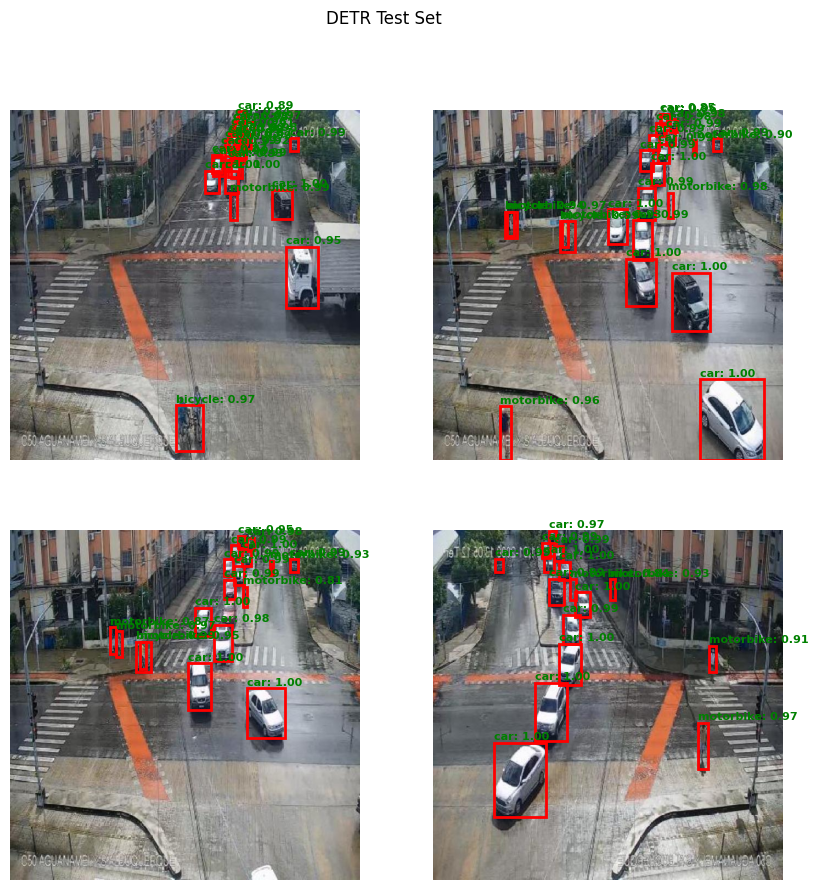

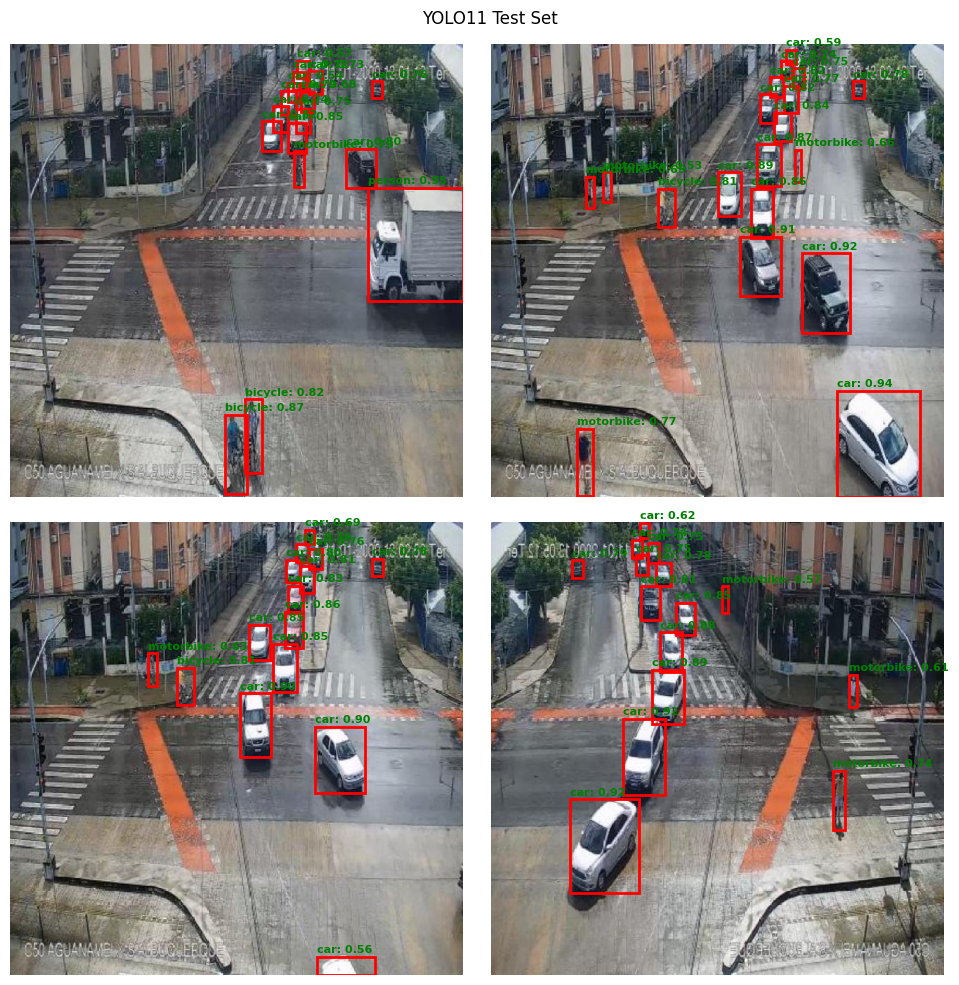

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(0)
test_paths = sorted(glob('datasets/test/images/*'))
names = {0: 'bicycle', 1: 'bus', 2: 'car', 3: 'motorbike', 4: 'person'}
transforms = T.Compose([
    T.Resize((800, 800)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load model
model_config=DetrConfig.from_pretrained("facebook/detr-resnet-50", num_labels=len(config["names"]), num_queries=config['num_queries'] )
model=DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50", config=model_config, ignore_mismatched_sizes=True).to(device)
ckp = torch.load(config['best_ckp'], map_location=device)
model.load_state_dict(ckp['model'])
model.eval().to(device)

def detr_preds(image: np.ndarray, threshold: float=0.8):
    img_pil= Image.fromarray(image)
    img_tensor= transforms(img_pil).to(device).unsqueeze(0)
    with torch.no_grad():
        pred=model(img_tensor)
        result=pred.logits.softmax(-1)[..., :-1].max(-1)
        scores, labels, boxes= result.values[0], result.indices[0], pred.pred_boxes[0]
        mask= scores > threshold
        boxes, scores, labels = boxes[mask], scores[mask], labels[mask]

    return boxes, scores, labels

# --------------DETR-----------------
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flat

for i, image_path in enumerate(test_paths[:4]):
    image = plt.imread(image_path)
    display_img = image.copy()
    axes[i].imshow(display_img)
    axes[i].axis('off')

    boxes, scores, labels=detr_preds(image)
    boxes=boxes.cpu().numpy()
    scores=scores.cpu().numpy()
    labels=labels.cpu().numpy()
    ori_h, ori_w= image.shape[:2]

    for box, score, label in zip(boxes, scores, labels):
        cx, cy, w, h = box
        x, y = cx - w/2, cy - h/2
        x, y, w, h = x * ori_w, y * ori_h, w * ori_w, h * ori_h
        axes[i].add_patch(Rectangle((x, y), w, h, edgecolor='red', facecolor='none', lw=2))
        axes[i].text(x, y-5, f"{names[label]}: {score:.2f}", color='green', fontsize=8, weight='bold')

plt.suptitle('DETR Test Set')

# ---------------YOLO11--------------------
yolo11 = YOLO("runs/yolo11/weights/best.pt")
yolo_results = yolo11.predict(test_paths, save=False, conf=0.5, verbose=False)[:4]

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flat

for i, result in enumerate(yolo_results):
    img = result.orig_img
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    for box in result.boxes:
        cx, cy, w, h = box.xywh[0].cpu().numpy()
        x, y = cx - w/2, cy - h/2
        score = box.conf.cpu().numpy()[0]
        label = result.names[int(box.cls)]
        axes[i].add_patch(Rectangle((x, y), w, h, edgecolor='red', facecolor='none', lw=2))
        axes[i].text(x, y-5, f"{label}: {score:.2f}", color='green', fontsize=8, weight='bold')
    axes[i].axis('off')

plt.suptitle('YOLO11 Test Set')
plt.tight_layout()
plt.show()

<div style="background-color: rgb(208, 242, 255); padding: 20px; font-family: Arial, sans-serif; color: #333; line-height: 1.5;">

### **Learning Rate Schedulers**
Learning rate schedulers are techniques that dinamically adjust the learning rate during training based on predefined rules or schedules. Common schedulers include: <br>
**StepLr**: Reduces learning rate at fixed intervals <br>
**ReduceLROnPlateau**: Reduces learning rate when performance plateaus <br>
**CosineAnnealingLR** (our focus)

---

### **CosineAnnealingLR**
**CosineAnnealingLR** is a Pytorch scheduler that adjusts the learning rate following a cosine annealing schedule, inspired by the paper [SGDR: Stochastic Gradient Descent with Warm Restarts](https://arxiv.org/abs/1608.03983). This implementation focuses on the cosine decay without warm restarts.<br>
**How it work** <br>
The learning rate decays from the initial value ($\eta_{\text{max}}$) to a minimum value ($\eta_{\text{min}}$) over $T_{\text{max}}$ epochs using:

$$ 
\eta_t = \eta_{\text{min}} + \frac{1}{2}(\eta_{\text{max}} - \eta_{\text{min}})(1 + \cos(\frac{t}{T_{\text{max}}}\pi)) 
$$ 

**Parameters**:
- $\eta_t$: Current learning rate at epoch $t$
- $\eta_{\text{max}}$: Initial learning rate (set in optimizer)
- $\eta_{\text{min}}$: Minimum learning rate (default: 0)
- $T_{\text{max}}$: Epochs per decay cycle

---

### **Confusion Matrix in Object Detection** 
The confusion matrix is a tool to evaluate how well a model. Unlike simple image classification, where each image has one label, object detection involves finding and classifying multiple objects, each with its own bounding box. This makes the confusion matrix more complex, as it needs to consider where the objects are (localization) and what they are (classification). <br>
- **Matching Step:** For each ground truth box, it finds the predicted box with the highest IoU, provided it's above a threshold (often 0.5). This ensures the prediction is close enough to the actual object. <br>
- **Classification Step:** <br>
If the predicted box matches a ground truth box and the class is correct, it's a **true positive (TP)** for that class. <br>
If the predicted box doesn't match any ground truth (or matches but with the wrong class), it's a **false positive (FP)** <br>
IF a ground truth box has no matching prediction, it's a **false positive (FP)** <br>
</div>

### Dert's metrics  

In [ ]:
# Compute DETR's confusion matrix
cm_dataset=sv.DetectionDataset.from_yolo(
    images_directory_path='datasets/valid/images',
    annotations_directory_path='datasets/valid/labels',
    data_yaml_path='src/data.yaml',
)
def detr_callback(image: np.array):
    boxes, scores, labels= detr_preds(image)
    xyxy=box_convert(boxes, in_fmt='cxcywh', out_fmt='xyxy')*torch.tensor([image.shape[1], image.shape[0], image.shape[1], image.shape[0]], device=device)

    return sv.Detections(
        xyxy= xyxy.cpu().numpy(),
        confidence=scores.cpu().numpy(),
        class_id=labels.cpu().numpy(),
    )   
cm= sv.ConfusionMatrix.benchmark(dataset=cm_dataset, callback=detr_callback)

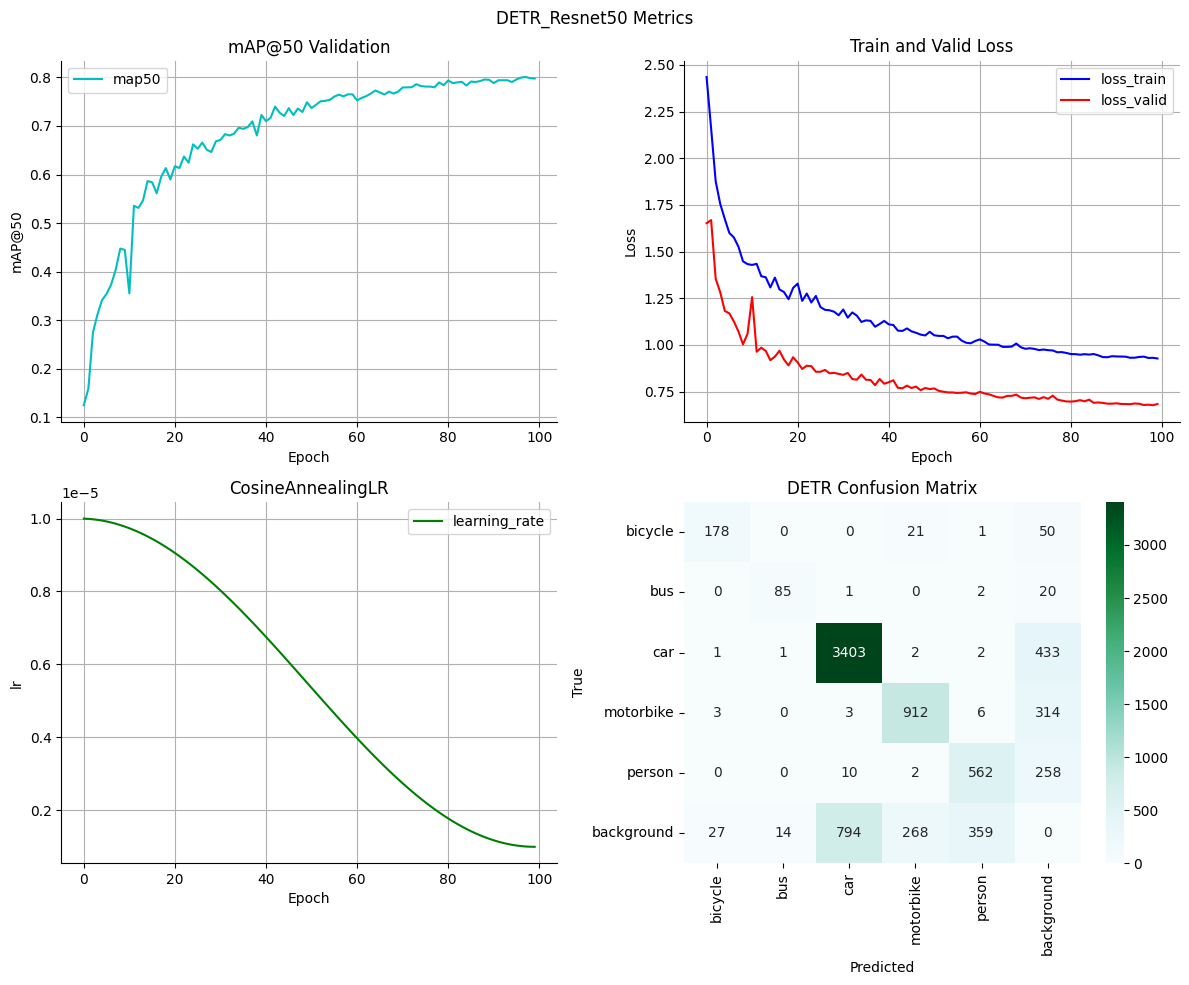

In [11]:
data = {k: pd.read_csv(f"runs/detr/results/{k}.csv") for k in ["map50", "lr", "loss_train", "loss_valid"]}

def plot_metrics(ax, dfs, labels, colors, title, ylabel):
    for df, label, color in zip(dfs, labels, colors):
        ax.plot(df["Step"], df["Value"], color, label=label)

    ax.spines[['top', 'right']].set_visible(False)
    ax.set_title(f"{title}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel(ylabel)
    ax.grid(True)
    ax.legend()

fig, axes= plt.subplots(2,2, figsize=(12,10))
axes = axes.flatten()
plot_metrics(axes[0], [data['map50']], ['map50'],colors= 'cyan', title='mAP@50 Validation', ylabel='mAP@50'  )
plot_metrics(axes[1], [data['loss_train'], data['loss_valid']], ['loss_train', 'loss_valid'], ['blue', 'red'], title='Train and Valid Loss', ylabel='Loss'  )
plot_metrics(axes[2], [data['lr']], ['learning_rate'], ['green'], title='CosineAnnealingLR', ylabel='lr'  )

cm_plot=sns.heatmap(cm.matrix, annot=True, fmt='.0f', cmap='BuGn', 
                    ax=axes[3], yticklabels=cm.classes+['background'], xticklabels=cm.classes+['background'])
axes[3].set_xlabel('Predicted')
axes[3].set_ylabel('True')
axes[3].set_title('DETR Confusion Matrix')

plt.suptitle("DETR_Resnet50 Metrics")
plt.tight_layout()
plt.show()

### YOLO11's metrics

In [12]:
import glob
from collections import Counter

label_files = glob.glob('datasets/valid/labels/*.txt')
counts = Counter()

for file in label_files:
    with open(file) as f:
        for line in f:
            class_id = int(line.strip().split()[0])
            counts[class_id] += 1

print("Objects per class:", counts)

Objects per class: Counter({2: 3842, 3: 1238, 4: 832, 0: 250, 1: 108})


<img src="./images/PR_curve.png" width="500" alt="PR_Curve">
<img src="./images/F1_curve.png" width="500" alt="F1_Curve">
<img src="./images/results.png" width="1000" alt="results">
<img src="./images/confusion_matrix.png" width="1000" alt="cm">
<img src="./images/confusion_matrix_normalized.png" width="1000" alt="cmn">

# 🧠 Conclusion
<div style="background-color: rgb(208, 242, 255); padding: 20px; font-family: Arial, sans-serif; color: #333; line-height: 1.5;">
The experiments reveal a clear performance gap: **YOLOv11n achives approximately 0.95 mAP@50 in just 50 epochs**, significantly outperforming DETR-Resnet50's 0.8 mAP@50 after 100 epochs. This 15% accuracy advantage, combined with YOLOv11n's **2x faster convergence**, demonstrates its superior efficiency for traffic object detection tasks. 

- **YOLO11:** *Introduces a significant change by replacing the **C2f block** in the neck with the **C3k2 block**. The **C3k2 block**
is designed to be faster and more efficient, enhancing the overall performance of the feature aggregation process* (2). <br>YOLOv11 employs multiple C3k2 blocks within its head structure to efficiently process and further refine the multi-scale feature maps. 

- **DETR:** Relies on transformers, which struggle with small objects due to **fixed-length queries** and **lack of multi-scale priors**. 
<div>

# 📚 References  
1. **YOLO11**:
[Ultralytics Documentation](https://docs.ultralytics.com/models/yolo11/)  
2. **YOLOv11: An Overview of the Key Architectural Enhancements**:
[[arXiv](https://www.arxiv.org/abs/2410.17725)]
3. **DETR**: End-to-End Object Detection with Transformers
[[arXiv](https://arxiv.org/abs/2005.12872)]  
4. **Resnet-50**: Deep Residual Learning for Image Recognition
[[arXiv](https://arxiv.org/abs/1512.03385)]  
5. **CosineAnnealingLR**: [[PyTorch Docs](https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html#)]  